In [2]:
pip install tensorflow-macos tensorflow-metal

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
train_df = pd.read_csv('dengue_train_engineered.csv')
test_df = pd.read_csv('dengue_test_engineered.csv')

In [6]:
train_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,optimal_temp,optimal_humidity,optimal_breeding,ndvi_avg,reanalysis_air_temp_k_anomaly,reanalysis_relative_humidity_percent_anomaly,precipitation_amt_mm_anomaly,reanalysis_specific_humidity_g_per_kg_anomaly,precipitation_amt_mm_log,station_precip_mm_log
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,-1.275676,...,0,0,0,0.150606,-0.952615,-1.420812,-21.706000,-1.282393,2.596746,2.833213
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,-0.732817,...,0,0,0,0.157479,-0.481570,-0.199542,-1.742667,-0.423144,3.170526,2.261763
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,-0.248251,...,0,0,0,0.133315,-0.025989,0.697426,0.603333,0.308602,3.570659,3.747148
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,-0.073370,...,0,0,0,0.209286,-0.230260,-0.075571,-39.867333,-0.226653,2.794839,1.609438
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,0.378405,...,0,0,0,0.239235,0.110515,-0.183972,-58.974000,-0.025925,2.142416,1.916923


In [7]:
from sklearn.preprocessing import OneHotEncoder

In [8]:
train_df = train_df.drop(columns=['week_start_date'])
test_df = test_df.drop(columns=['week_start_date'])

In [9]:
encoder = OneHotEncoder(sparse_output=False)
city_train_encoded = encoder.fit_transform(train_df[['city']])
city_test_encoded = encoder.transform(test_df[['city']])

train_df_encoded = train_df.drop(columns=['city'])
test_df_encoded = test_df.drop(columns=['city'])

In [10]:
for i, city in enumerate(encoder.categories_[0]):
    train_df_encoded[f'city_{city}'] = city_train_encoded[:, i]
    test_df_encoded[f'city_{city}'] = city_test_encoded[:, i]

In [11]:
target_column = 'total_cases'

In [12]:
X_train = train_df_encoded.drop(columns=[target_column])
y_train = train_df_encoded[target_column].values.reshape(-1, 1)

X_test = test_df_encoded.drop(columns=[target_column])
y_test = test_df_encoded[target_column].values.reshape(-1, 1)

In [13]:
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

In [14]:
def create_sequences(X, y, time_steps=10):
    """
    Create sequences for LSTM model
    X: feature data
    y: target data
    time_steps: lookback window size
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
time_steps = 10

In [16]:
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

print(f"Training data shape: {X_train_seq.shape}")
print(f"Testing data shape: {X_test_seq.shape}")

Training data shape: (1154, 10, 207)
Testing data shape: (282, 10, 207)


In [17]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2025-04-10 13:49:02.760453: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-10 13:49:02.761969: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-10 13:49:02.761986: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-10 13:49:02.767495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-10 13:49:02.767524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

In [18]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


2025-04-10 13:49:04.757692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-10 13:49:04.763737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - loss: 0.0245 - val_loss: 8.0325e-04
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 0.0081 - val_loss: 0.0024
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 0.0101 - val_loss: 7.8265e-04
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 0.0093 - val_loss: 7.9820e-04
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 0.0059 - val_loss: 7.0624e-04
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 0.0047 - val_loss: 9.6267e-04
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 0.0063 - val_loss: 7.3367e-04
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 0.0037 - val_loss: 6.9979e-04
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - loss: 0.0052 - val_loss: 6.8645e-04
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 0.0050 - val_loss: 8.2291e-04
Epoch 12/100
29/2

In [19]:
y_pred_scaled = model.predict(X_test_seq)

y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test_seq)

mae = mean_absolute_error(y_test_actual, y_pred)
print(f"Mean Absolute Error: {mae}")

1/9 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step

2025-04-10 13:51:17.707680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Mean Absolute Error: 12.829672500174096


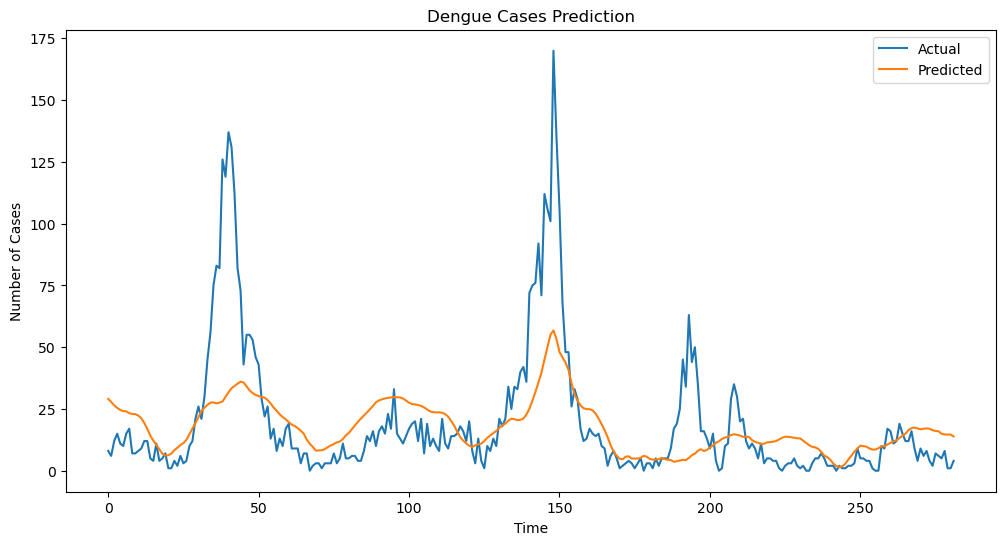

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Dengue Cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

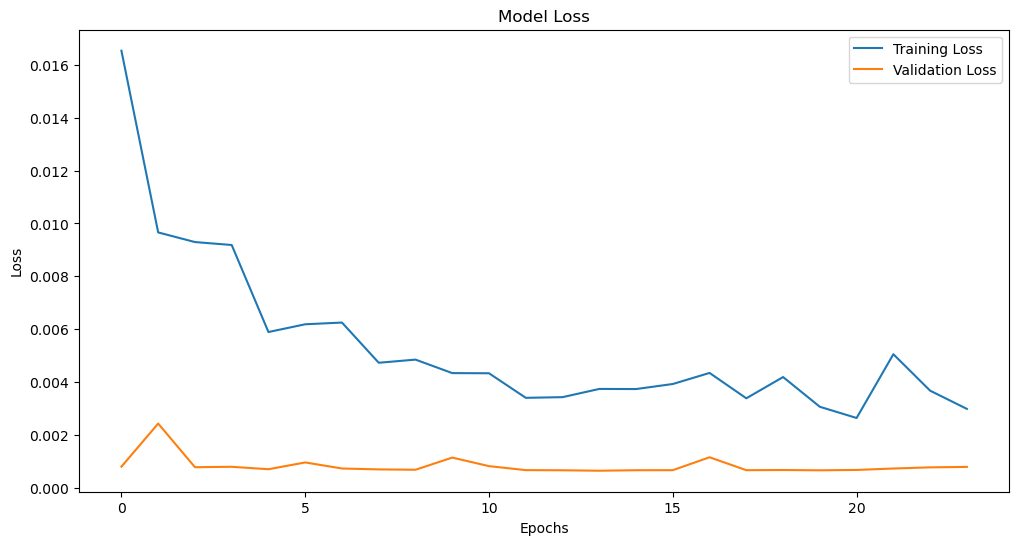

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Markdown coming soon! Baseline of 12.82 MAE for combined cities, out performed both previous models. Lets keep going!

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [38]:
time_steps = 52

In [62]:
X_train_seq_2, y_train_seq_2 = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq_2, y_test_seq_2 = create_sequences(X_test_scaled, y_test_scaled, time_steps)

print(f"Training data shape: {X_train_seq_2.shape}")
print(f"Testing data shape: {X_test_seq_2.shape}")

Training data shape: (1112, 52, 207)
Testing data shape: (240, 52, 207)


In [63]:
model_2 = Sequential()
model_2.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_seq_2.shape[1], X_train_seq_2.shape[2])))
model_2.add(Dropout(0.2))
model_2.add(LSTM(100, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(1))

model_2.compile(optimizer='adam', loss='mean_absolute_error')

early_stop_2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
history_2 = model_2.fit(
    X_train_seq_2, y_train_seq_2,
    epochs=150,  
    batch_size=32,  
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/150


2025-04-10 17:13:02.316137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.1158

2025-04-10 17:14:46.318251: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


28/28 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - loss: 0.1144 - val_loss: 0.0143
Epoch 2/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - loss: 0.0416 - val_loss: 0.0138
Epoch 3/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - loss: 0.0443 - val_loss: 0.0165
Epoch 4/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - loss: 0.0407 - val_loss: 0.0184
Epoch 5/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - loss: 0.0355 - val_loss: 0.0169
Epoch 6/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - loss: 0.0334 - val_loss: 0.0130
Epoch 7/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - loss: 0.0339 - val_loss: 0.0167
Epoch 8/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - loss: 0.0357 - val_loss: 0.0182
Epoch 9/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - loss: 0.0292 - val_loss: 0.0150
Epoch 10/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - loss: 0.0328 - val_loss: 0.0181
Epoch 11/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - loss: 0.0332 - val_loss: 0.0164
Epoch 12/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - loss: 0.0

In [65]:
y_pred_scaled_2 = model_2.predict(X_test_seq_2)

y_pred_2 = target_scaler.inverse_transform(y_pred_scaled_2)
y_test_actual_2 = target_scaler.inverse_transform(y_test_seq_2)

mae_2 = mean_absolute_error(y_test_actual_2, y_pred_2)
print(f"Mean Absolute Error: {mae_2}")

2025-04-10 18:01:44.519084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step
Mean Absolute Error: 13.241294038295745


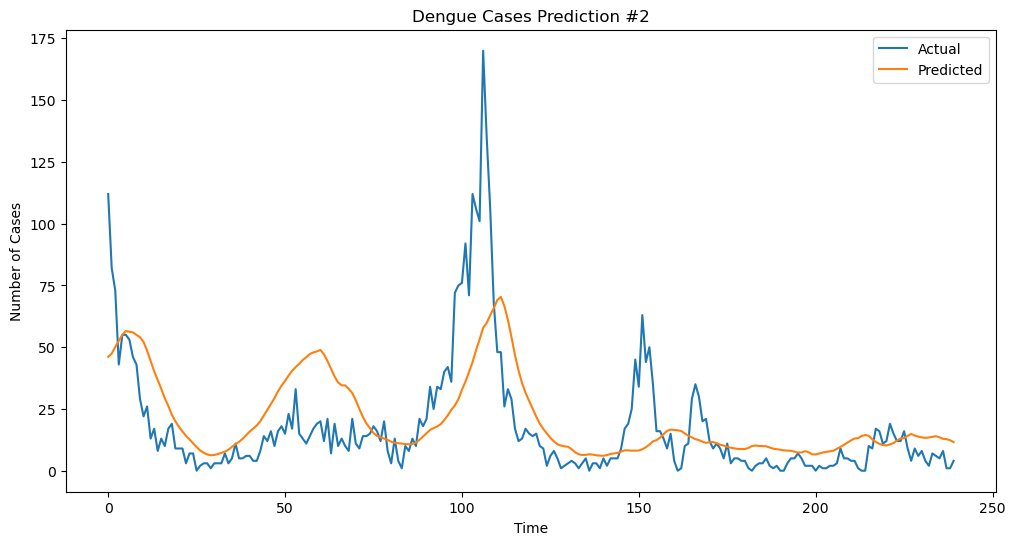

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_2, label='Actual')
plt.plot(y_pred_2, label='Predicted')
plt.title('Dengue Cases Prediction #2')
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

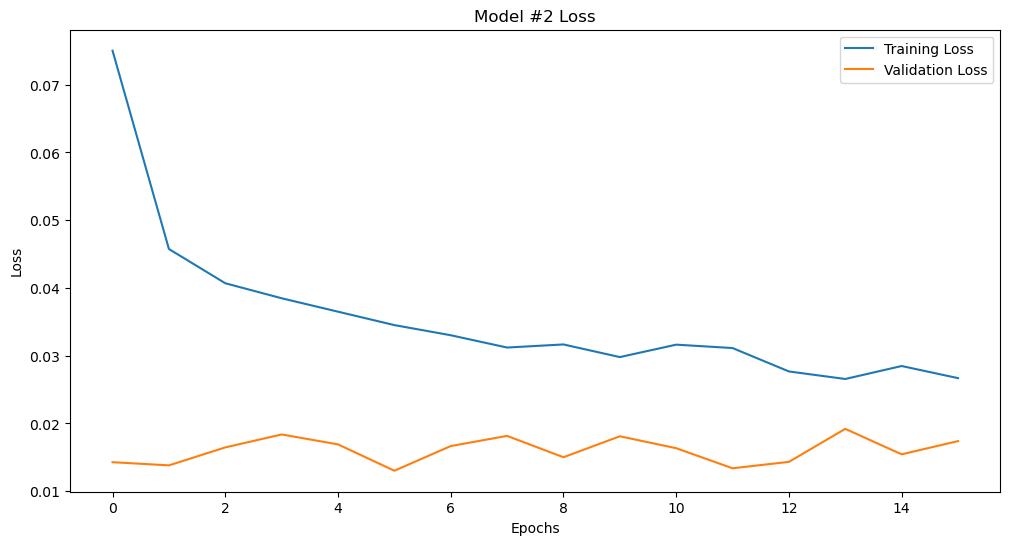

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model #2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE went up a bit, but we move on. Moving onto model 3. Implementing Bidirectional with hopes of improving performance

In [68]:
from tensorflow.keras.layers import Bidirectional

model_3 = Sequential()
model_3.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_3.add(Dropout(0.3))
model_3.add(Bidirectional(LSTM(64, activation='relu')))
model_3.add(Dropout(0.3))
model_3.add(Dense(1))

model_3.compile(optimizer='adam', loss='mean_absolute_error')

early_stop_3 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
history_3 = model_3.fit(
    X_train_seq_2, 
    y_train_seq_2,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop_3],
    verbose=1
)

Epoch 1/150


2025-04-10 18:03:53.232025: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.2037

2025-04-10 18:07:23.711607: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


28/28 ━━━━━━━━━━━━━━━━━━━━ 217s 8s/step - loss: 0.2007 - val_loss: 0.0357
Epoch 2/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 238s 9s/step - loss: 0.0503 - val_loss: 0.0133
Epoch 3/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 234s 8s/step - loss: 0.0457 - val_loss: 0.0135
Epoch 4/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 251s 9s/step - loss: 0.0402 - val_loss: 0.0146
Epoch 5/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 239s 9s/step - loss: 0.0375 - val_loss: 0.0136
Epoch 6/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 247s 9s/step - loss: 0.0386 - val_loss: 0.0131
Epoch 7/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 241s 9s/step - loss: 0.0363 - val_loss: 0.0132
Epoch 8/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 235s 8s/step - loss: 0.0343 - val_loss: 0.0132
Epoch 9/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 239s 9s/step - loss: 0.0288 - val_loss: 0.0155
Epoch 10/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 252s 9s/step - loss: 0.0290 - val_loss: 0.0136
Epoch 11/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 241s 9s/step - loss: 0.0294 - val_loss: 0.0124
Epoch 12/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 239s 9s/step - loss: 0.0

In [70]:
y_pred_scaled_3 = model_3.predict(X_test_seq_2)

y_pred_3 = target_scaler.inverse_transform(y_pred_scaled_3)
y_test_actual_3 = target_scaler.inverse_transform(y_test_seq_2)

mae_3 = mean_absolute_error(y_test_actual_3, y_pred_3)
print(f"Mean Absolute Error: {mae_3}")

2025-04-10 22:39:11.637774: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 582ms/step
Mean Absolute Error: 11.208264489471912


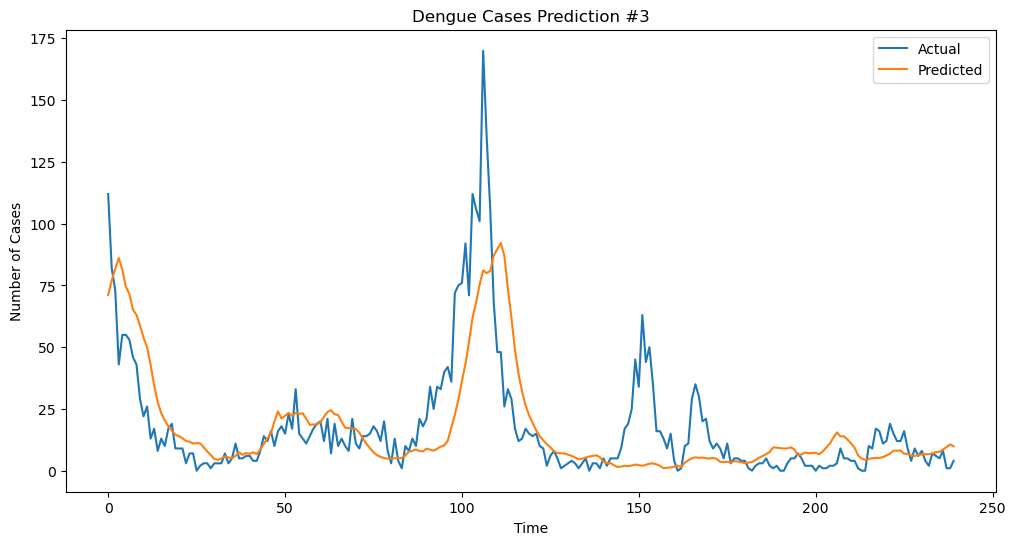

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_3, label='Actual')
plt.plot(y_pred_3, label='Predicted')
plt.title('Dengue Cases Prediction #3')
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

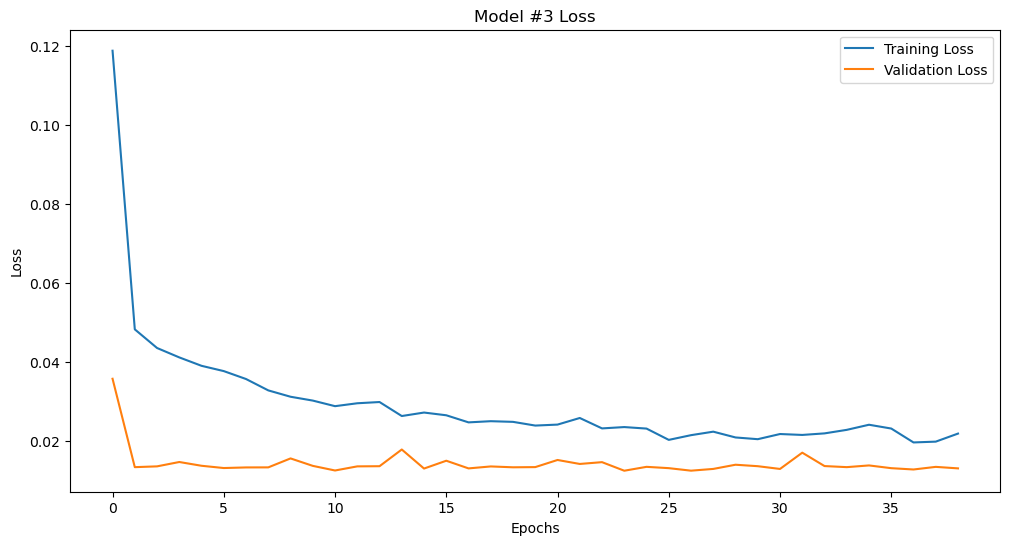

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Model #3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 11.20 MAE

In [75]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

model_4 = Sequential()
model_4.add(Bidirectional(LSTM(128, 
                           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),    
                           recurrent_regularizer=l1_l2(l1=0, l2=1e-4),    
                           bias_regularizer=l1_l2(l1=0, l2=1e-4),
                           return_sequences=True), 
             input_shape=(X_train_seq_2.shape[1], X_train_seq_2.shape[2])))
model_4.add(Dropout(0.3))
model_4.add(Bidirectional(LSTM(128, 
                           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                           recurrent_regularizer=l1_l2(l1=0, l2=1e-4))))
model_4.add(Dropout(0.3))
model_4.add(Dense(1))

model_4.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False),
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

early_stop_4 = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=15, verbose=1, restore_best_weights=True, mode='min')

In [77]:
history_4 = model_4.fit(
    X_train_seq_2, y_train_seq_2,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 293ms/step - loss: 0.9934 - mean_absolute_error: 0.5792 - val_loss: 0.4210 - val_mean_absolute_error: 0.0169
Epoch 2/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 0.4803 - mean_absolute_error: 0.0811 - val_loss: 0.4142 - val_mean_absolute_error: 0.0309
Epoch 3/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 0.4382 - mean_absolute_error: 0.0605 - val_loss: 0.3884 - val_mean_absolute_error: 0.0277
Epoch 4/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 0.4118 - mean_absolute_error: 0.0566 - val_loss: 0.3545 - val_mean_absolute_error: 0.0159
Epoch 5/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - loss: 0.3774 - mean_absolute_error: 0.0441 - val_loss: 0.3555 - val_mean_absolute_error: 0.0378
Epoch 6/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 0.3524 - mean_absolute_error: 0.0397 - val_loss: 0.3209 - val_mean_absolute_error: 0.0226
Epoch 7/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 0.3355 - mean_absolute_error: 0.

In [78]:
y_pred_scaled_4 = model_4.predict(X_test_seq_2)

y_pred_4 = target_scaler.inverse_transform(y_pred_scaled_4)
y_test_actual_4 = target_scaler.inverse_transform(y_test_seq_2)

mae_4 = mean_absolute_error(y_test_actual_4, y_pred_4)
print(f"Mean Absolute Error: {mae_4}")

2025-04-10 23:29:25.367291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step
Mean Absolute Error: 10.016411252443989


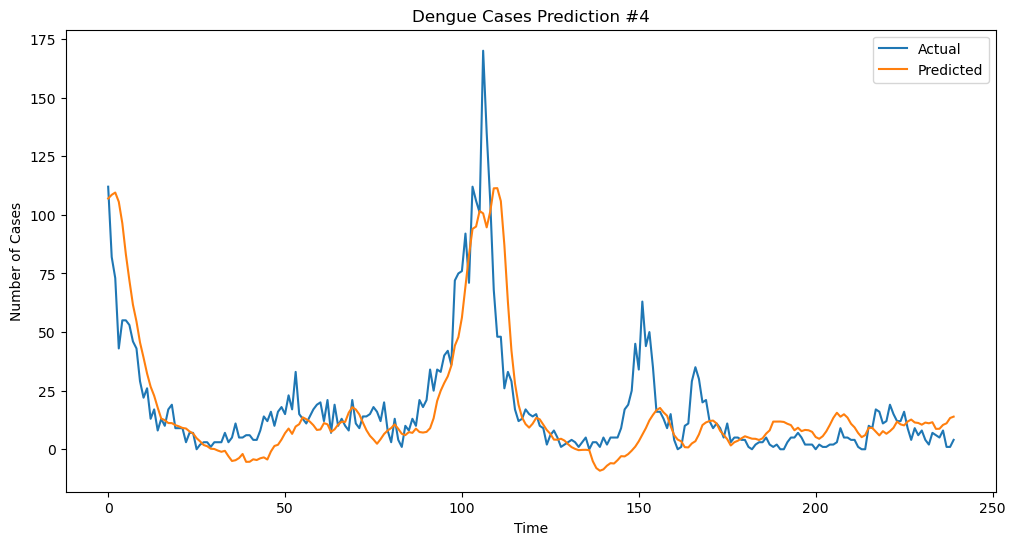

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_4, label='Actual')
plt.plot(y_pred_4, label='Predicted')
plt.title('Dengue Cases Prediction #4')
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

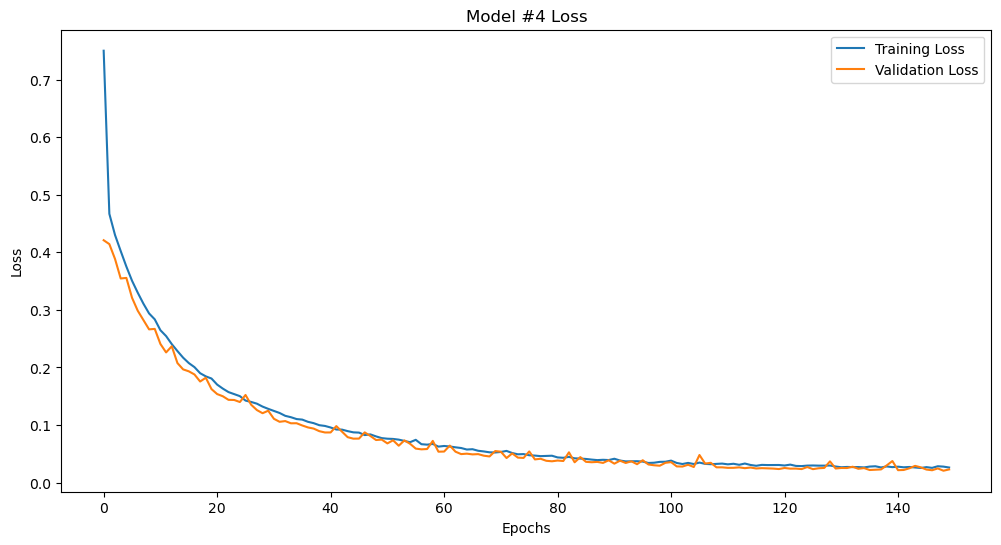

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(history_4.history['loss'], label='Training Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.title('Model #4 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 10.016 MAE

In [82]:
model_5 = Sequential()
model_5.add(Bidirectional(LSTM(128, 
                           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),    
                           recurrent_regularizer=l1_l2(l1=0, l2=1e-4),    
                           bias_regularizer=l1_l2(l1=0, l2=1e-4),
                           return_sequences=True), 
             input_shape=(X_train_seq_2.shape[1], X_train_seq_2.shape[2])))
model_5.add(Dropout(0.3))
model_5.add(Bidirectional(LSTM(128, 
                           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                           recurrent_regularizer=l1_l2(l1=0, l2=1e-4))))
model_5.add(Dropout(0.3))
model_5.add(Dense(1))

model_5.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False),
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

early_stop_5 = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=15, verbose=1, restore_best_weights=True, mode='min')
reduce_lr_5 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
history_5 = model_5.fit(
    X_train_seq_2, y_train_seq_2,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/150


2025-04-10 23:37:59.856826: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - loss: 0.8889 - mean_absolute_error: 0.4756 - val_loss: 0.4135 - val_mean_absolute_error: 0.0135 - learning_rate: 0.0010
Epoch 2/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - loss: 0.4806 - mean_absolute_error: 0.0864 - val_loss: 0.4243 - val_mean_absolute_error: 0.0489 - learning_rate: 0.0010
Epoch 3/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 0.4284 - mean_absolute_error: 0.0594 - val_loss: 0.3688 - val_mean_absolute_error: 0.0192 - learning_rate: 0.0010
Epoch 4/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - loss: 0.3941 - mean_absolute_error: 0.0508 - val_loss: 0.3410 - val_mean_absolute_error: 0.0160 - learning_rate: 0.0010
Epoch 5/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 0.3635 - mean_absolute_error: 0.0444 - val_loss: 0.3160 - val_mean_absolute_error: 0.0137 - learning_rate: 0.0010
Epoch 6/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - loss: 0.3400 - mean_absolute_error: 0.0430 - val_loss: 0.2952 - val_mean_absolute

In [84]:
y_pred_scaled_5 = model_5.predict(X_test_seq_2)

y_pred_5 = target_scaler.inverse_transform(y_pred_scaled_5)
y_test_actual_5 = target_scaler.inverse_transform(y_test_seq_2)

mae_5 = mean_absolute_error(y_test_actual_5, y_pred_5)
print(f"Mean Absolute Error: {mae_5}")

2025-04-11 00:12:00.577787: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step
Mean Absolute Error: 11.669192433559026


# Iteration 5 the MAE rose to 11.66, this model included reduce_lr. Removing reduce_lr and going to change the batch size, and extra LSTM layer, try different values for L1 and L2 penalties, etc.

In [90]:
from tensorflow.keras.layers import GRU

model_6 = Sequential()

# adding cell state configs and recurrent dropout to go alongside regularization
model_6 = Sequential()
model_6.add(Bidirectional(LSTM(128, 
                           activation='tanh',           
                           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),  
                           recurrent_regularizer=l1_l2(l1=0, l2=1e-4),  
                           bias_regularizer=l1_l2(l1=0, l2=1e-4),       
                           return_sequences=True), 
             input_shape=(X_train_seq_2.shape[1], X_train_seq_2.shape[2])))
model_6.add(Dropout(0.3))
model_6.add(Bidirectional(LSTM(128,            
                           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                           recurrent_regularizer=l1_l2(l1=0, l2=1e-4))))
model_6.add(Dropout(0.3))
model_6.add(Dense(1))

model_6.compile(optimizer=Adam(learning_rate=0.001, 
                              beta_1=0.9, 
                              beta_2=0.999, 
                              epsilon=1e-8, 
                              amsgrad=False),
               loss='mean_absolute_error',
               metrics=['mean_absolute_error'])

early_stop_6 = EarlyStopping(monitor='val_loss', 
                            min_delta=0.0001, 
                            patience=20,  
                            verbose=1, 
                            restore_best_weights=True, 
                            mode='min')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [91]:
history_6 = model_6.fit(
    X_train_seq_2, y_train_seq_2,
    epochs=200,  
    batch_size=16,  
    validation_split=0.2,
    callbacks=[early_stop_6],
    verbose=1
)

Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - loss: 0.6392 - mean_absolute_error: 0.2325 - val_loss: 0.4471 - val_mean_absolute_error: 0.0731
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.4352 - mean_absolute_error: 0.0731 - val_loss: 0.3420 - val_mean_absolute_error: 0.0152
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 0.3666 - mean_absolute_error: 0.0505 - val_loss: 0.3042 - val_mean_absolute_error: 0.0182
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 0.3198 - mean_absolute_error: 0.0427 - val_loss: 0.2671 - val_mean_absolute_error: 0.0151
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 0.2828 - mean_absolute_error: 0.0382 - val_loss: 0.2502 - val_mean_absolute_error: 0.0266
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - loss: 0.2571 - mean_absolute_error: 0.0397 - val_loss: 0.2156 - val_mean_absolute_error: 0.0156
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - loss: 0.2288 - mean_absolute_error: 

In [92]:
y_pred_scaled_6 = model_6.predict(X_test_seq_2)

y_pred_6 = target_scaler.inverse_transform(y_pred_scaled_6)
y_test_actual_6 = target_scaler.inverse_transform(y_test_seq_2)

mae_6 = mean_absolute_error(y_test_actual_6, y_pred_6)
print(f"Mean Absolute Error: {mae_6}")

2025-04-11 16:28:53.097647: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step
Mean Absolute Error: 9.645723270314436
